<a href="https://colab.research.google.com/github/dohyung-kim/ccri/blob/main/script/pixel/p1_normalization_pixel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 120.0 MB/s eta 0:00:00


In [2]:
import shutil

src = "/content/drive/MyDrive/ccri_pixel"
dst = "/content/ccri_image"

shutil.copytree(src, dst)
print("Folder copied successfully!")


Folder copied successfully!


In [34]:
import os
import glob
import numpy as np
import rasterio
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from scipy.stats import normaltest, probplot
from scipy.stats import skew, kurtosis
import pandas as pd
from sklearn.decomposition import PCA


In [4]:
# Define image folder and files
image_folder = dst
image_files = glob.glob(os.path.join(image_folder, "*.tif"))

# Load land-sea mask (1 = land, 0 = sea)
mask_path = os.path.join(image_folder, "landSeaMask.tif")
with rasterio.open(mask_path) as mask_src:
    landsea_mask = mask_src.read(1)  # Assuming single-band mask
    land_mask = landsea_mask == 1  # Boolean mask for land pixels

# Helper function to load images
def load_image(image_file):
    with rasterio.open(os.path.join(image_folder, image_file)) as src:
        data = src.read(1)  # Read the first band
        valid_data = np.where(land_mask, data, 0)  # Mask out sea area
        valid_data = np.nan_to_num(valid_data)  # Convert NaNs to zero
        return valid_data

# Load images and apply log transformation and z-score scaling
scaler = StandardScaler()

#function to trim outliers and return trimmed value and min and max values
def trim_outliers_iteratively(values, max_skew=2, max_kurtosis=3.5):
    """
    Iteratively removes extreme min/max values until skewness <= 2 and kurtosis <= 3.5.
    Returns the trimmed dataset along with the final min and max.
    """
    values_tmp = values.copy()  # Ensure no NaNs
    while True:
        current_skew = skew(values_tmp)
        current_kurtosis = kurtosis(values_tmp)

        if abs(current_skew) <= max_skew and current_kurtosis <= max_kurtosis:
            break  # Stop if conditions are met

        # Remove min and max values
        min_val, max_val = values_tmp.min(), values_tmp.max()
        values_tmp = values_tmp[(values_tmp > min_val) & (values_tmp < max_val)]  # Trim extreme min/max

    values = np.clip(values, values_tmp.min(), values_tmp.max())
    return values, values.min(), values.max()




/content/ccri_image/heatwave_severity_ecmwf_2014-2024.tif: Log Transformation and z-score Scaling - skew=-0.119, kurtosis=-0.939


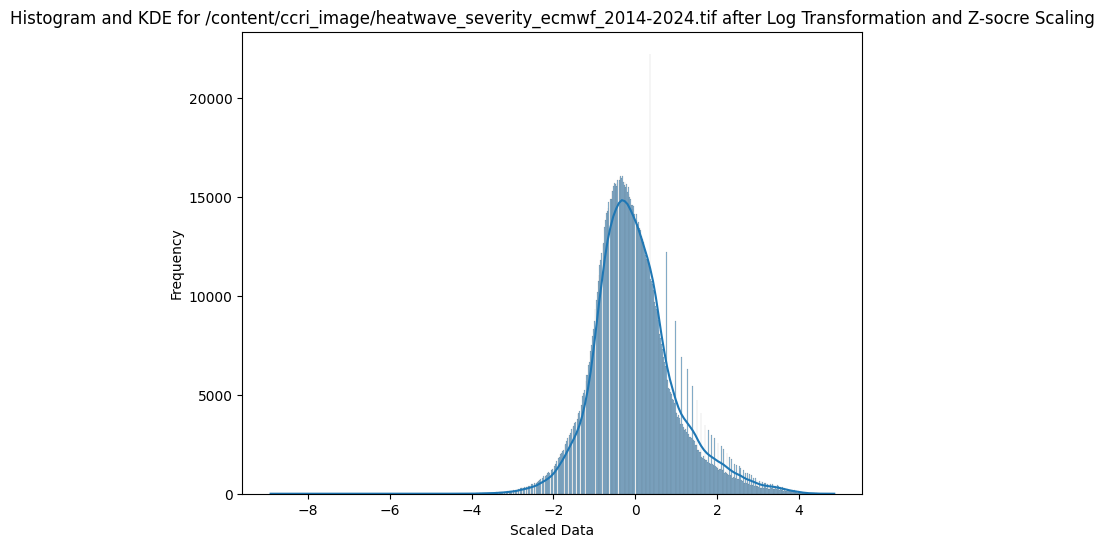

/content/ccri_image/coastal_flood_100yr_jrc_2024.tif: Log Transformation and z-score Scaling - skew=-0.119, kurtosis=-0.939


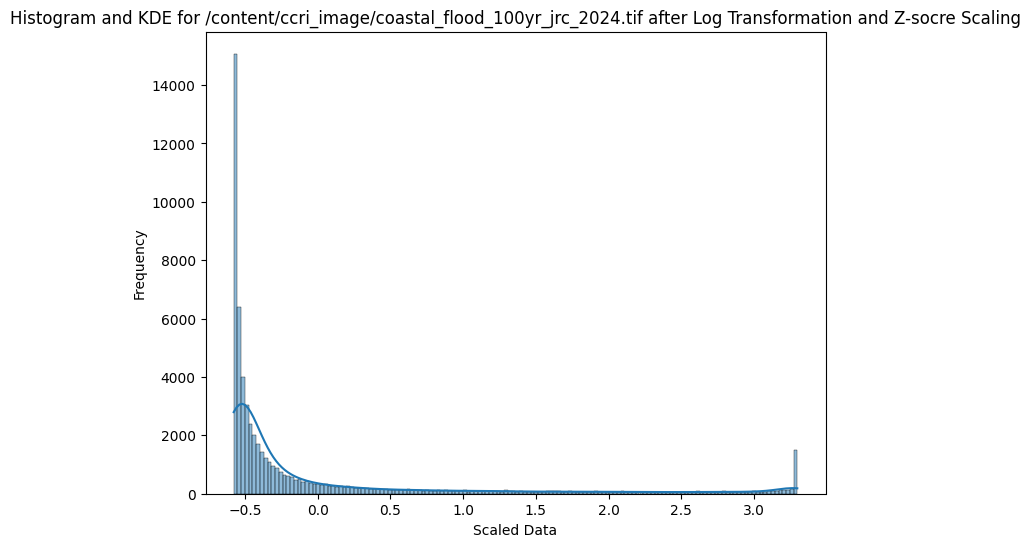

/content/ccri_image/extreme_heat_ecmwf_2014-2024.tif: Log Transformation and z-score Scaling - skew=-0.119, kurtosis=-0.939


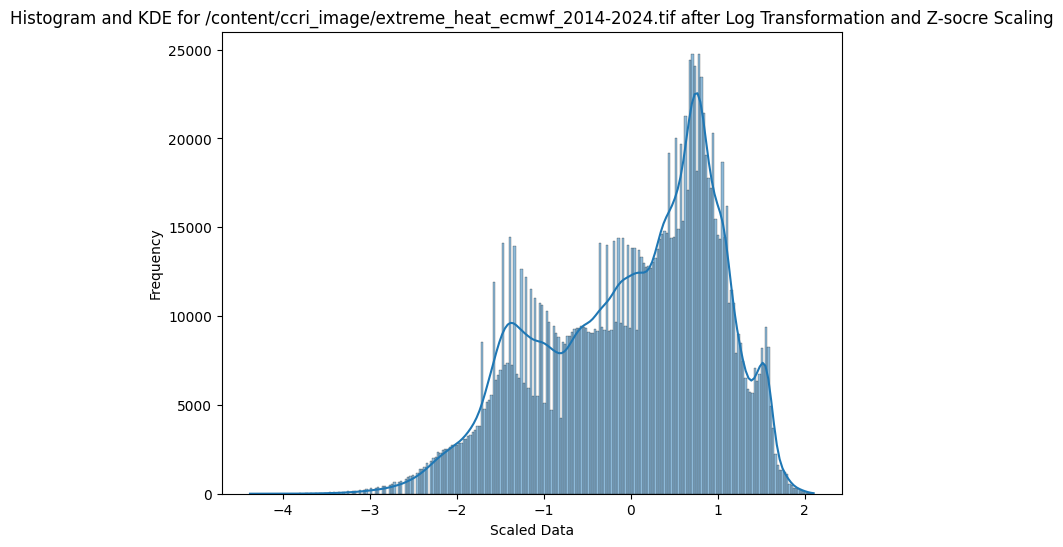

/content/ccri_image/river_flood_100yr_jrc_2024.tif: Log Transformation and z-score Scaling - skew=-0.119, kurtosis=-0.939


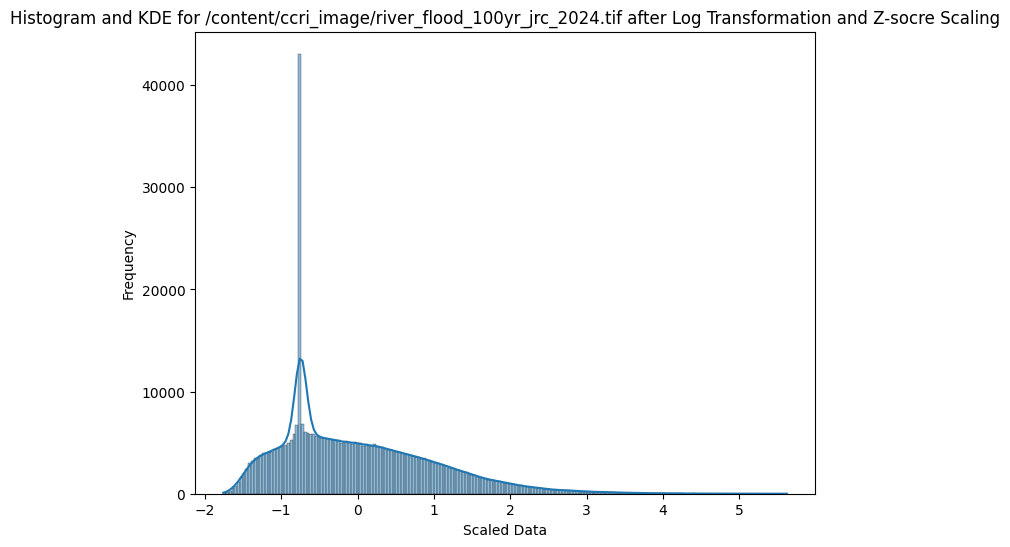

/content/ccri_image/vectorborne_malariapf_2012-2022.tif: Log Transformation and z-score Scaling - skew=-0.119, kurtosis=-0.939


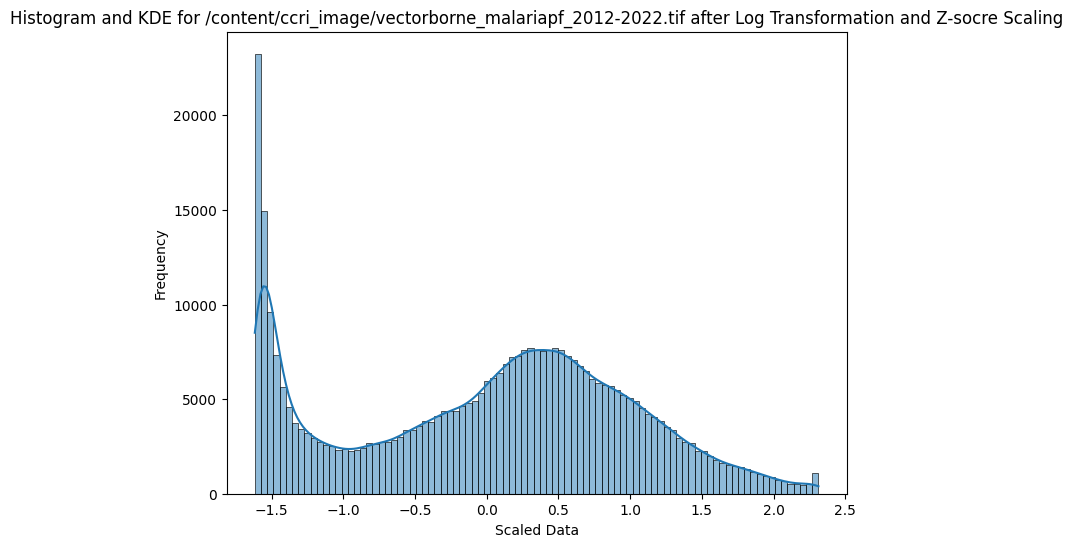

/content/ccri_image/heatwave_frequency_ecmwf_2014-2024.tif: Log Transformation and z-score Scaling - skew=-0.119, kurtosis=-0.939


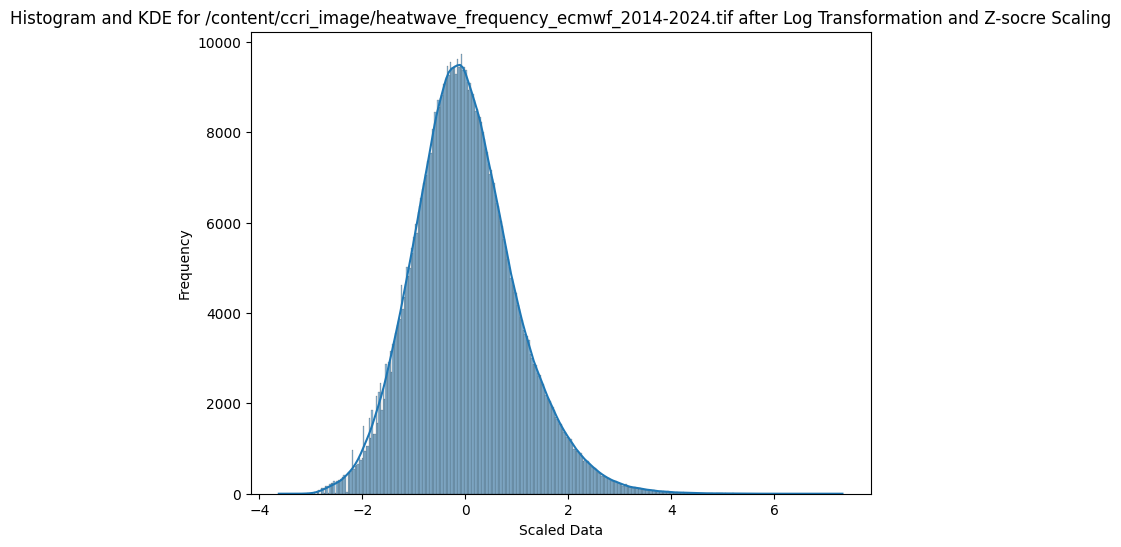

/content/ccri_image/fire_FRP_nasa_2001-2024.tif: Log Transformation and z-score Scaling - skew=-0.119, kurtosis=-0.939


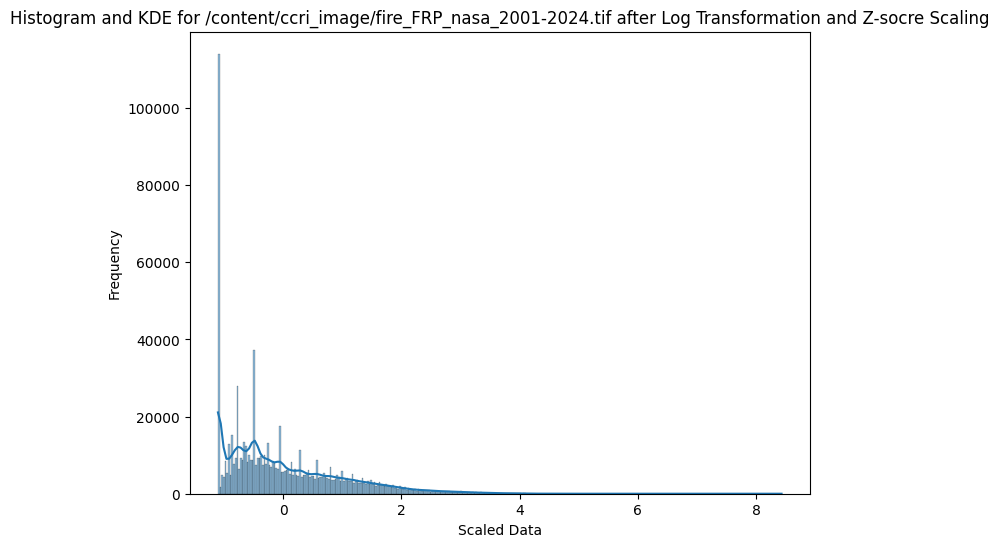

/content/ccri_image/tropical_storm_100yr_giri_2024.tif: Log Transformation and z-score Scaling - skew=-0.119, kurtosis=-0.939


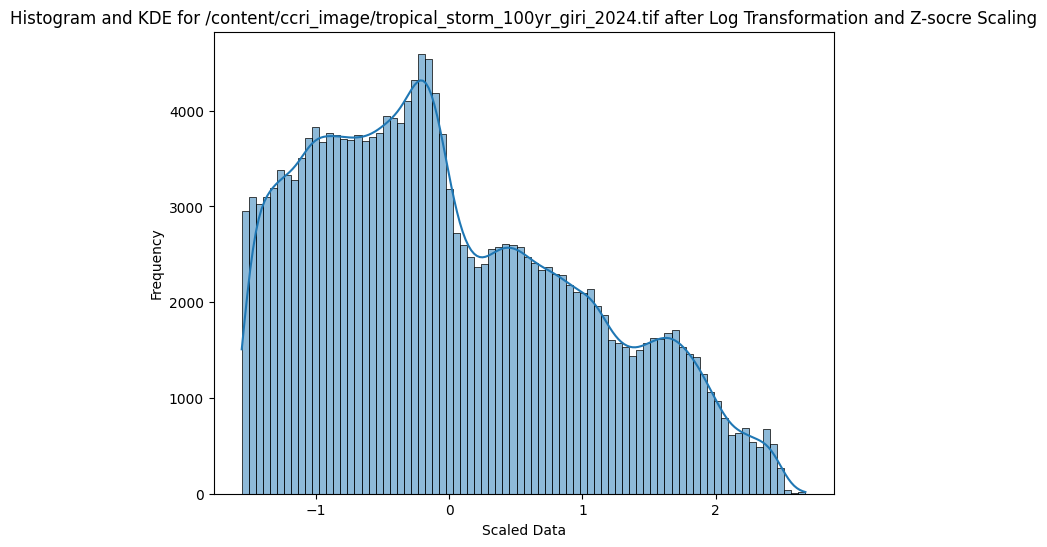

/content/ccri_image/heatwave_duration_ecmwf_2014-2024.tif: Log Transformation and z-score Scaling - skew=-0.119, kurtosis=-0.939


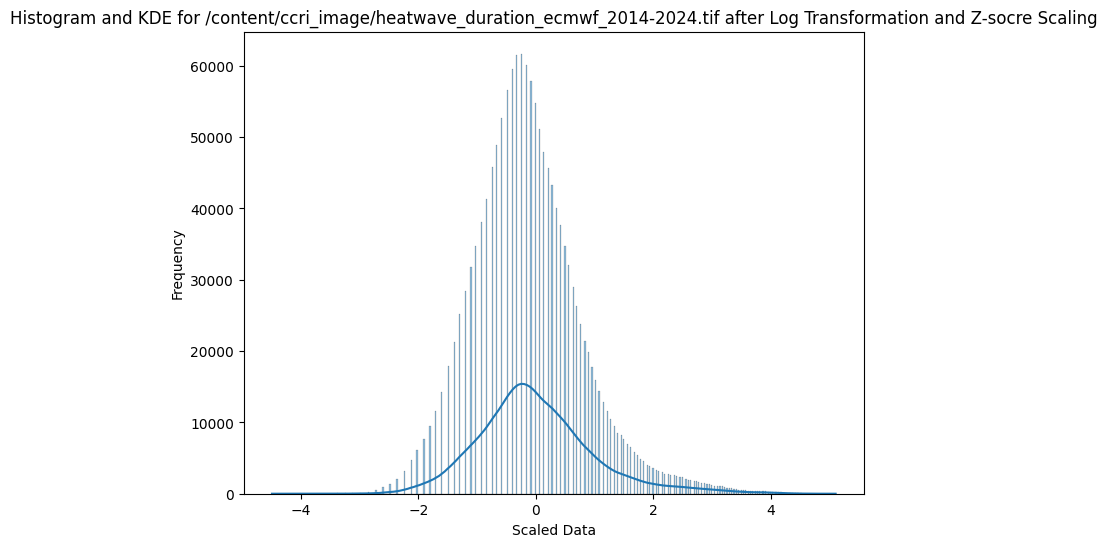

/content/ccri_image/sand_dust_storm_unccd_2024.tif: Log Transformation and z-score Scaling - skew=-0.119, kurtosis=-0.939


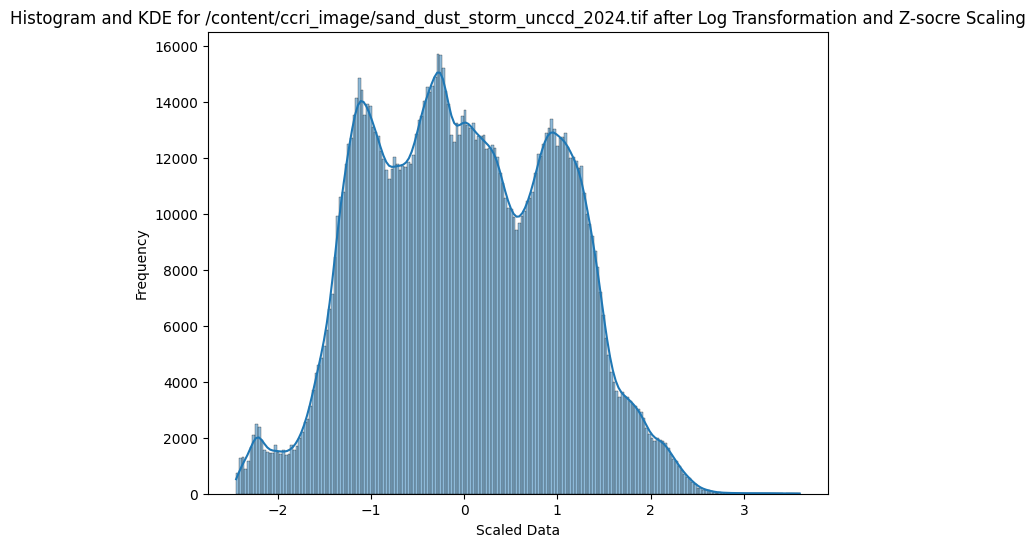

/content/ccri_image/air_pollution_pm25_2012-2022.tif: Log Transformation and z-score Scaling - skew=-0.119, kurtosis=-0.939


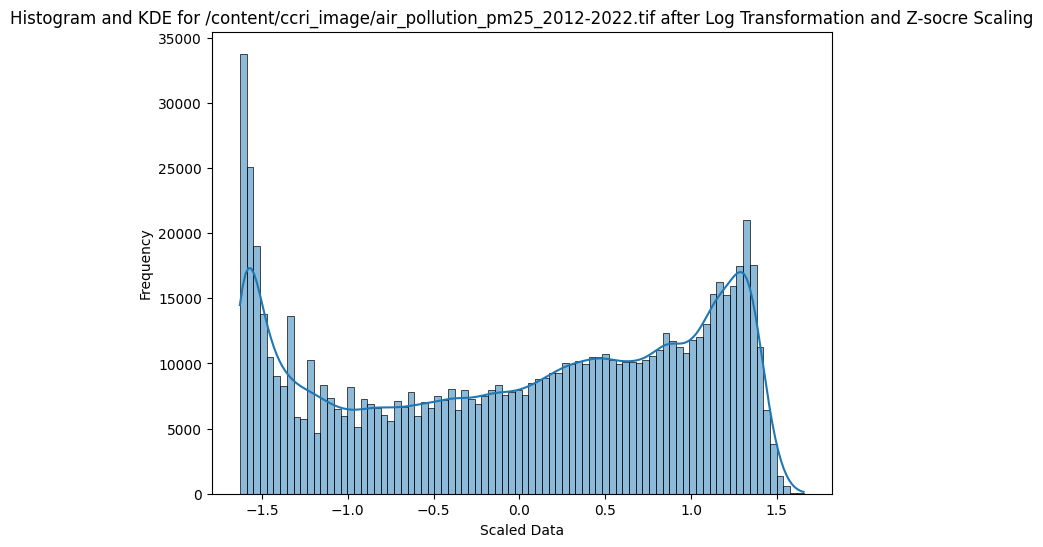

/content/ccri_image/agricultural_drought_fao_1984-2023.tif: Log Transformation and z-score Scaling - skew=-0.119, kurtosis=-0.939


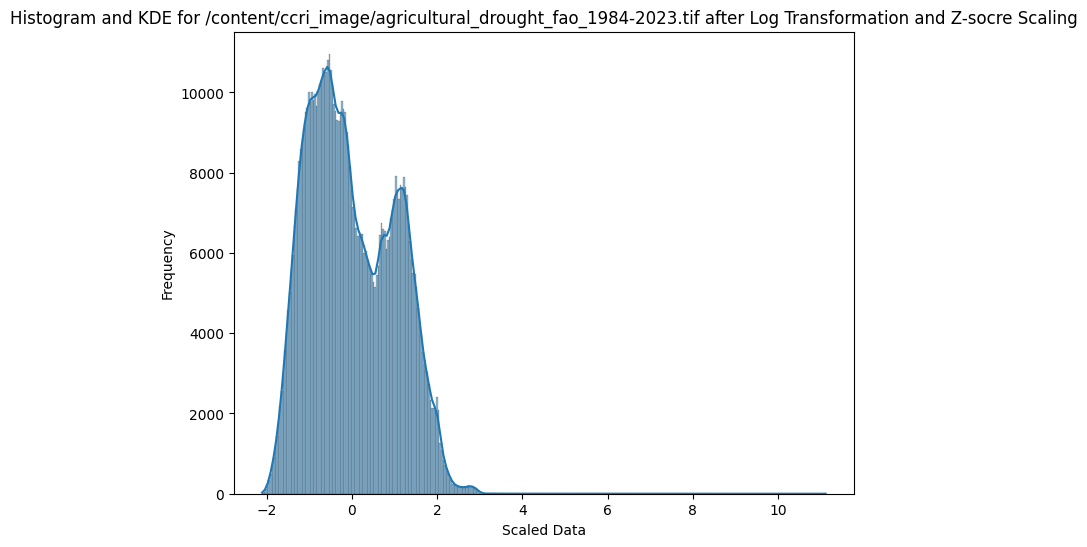

/content/ccri_image/fire_frequency_nasa_2001-2023.tif: Log Transformation and z-score Scaling - skew=-0.119, kurtosis=-0.939


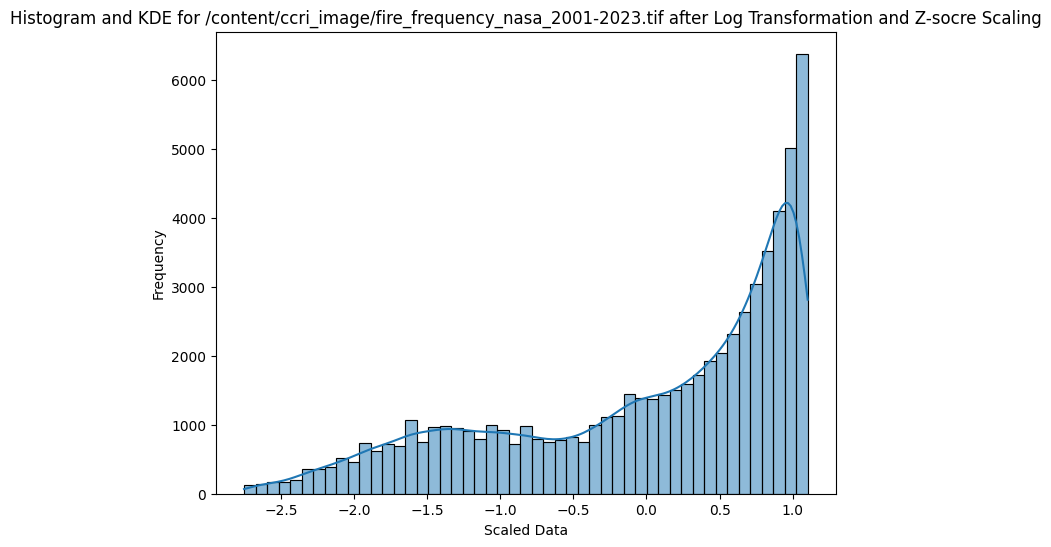

/content/ccri_image/vectorborne_malariapv_2012-2022.tif: Log Transformation and z-score Scaling - skew=-0.119, kurtosis=-0.939


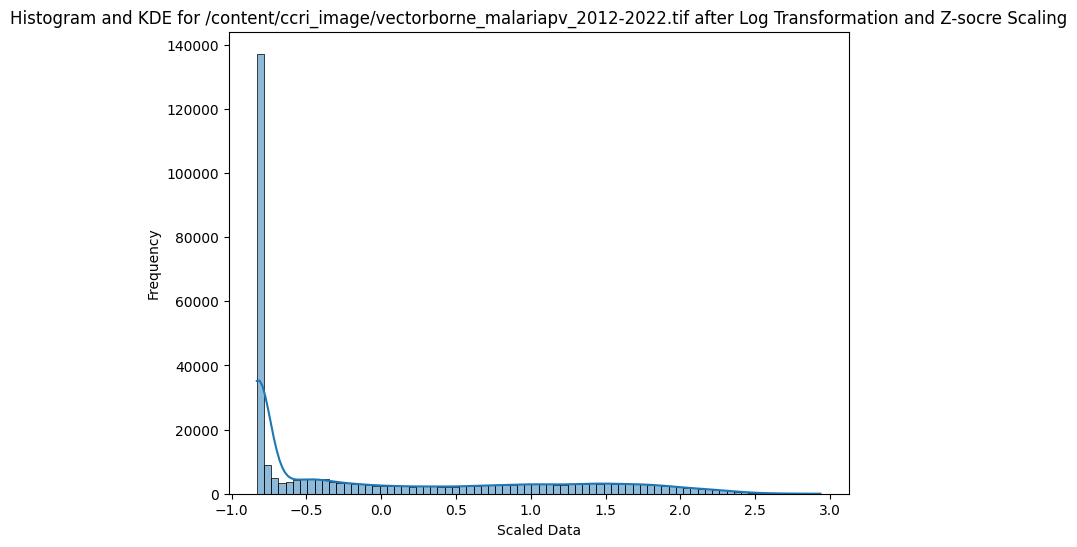

In [11]:
#plot data ditribution after log transformation and z-scor based normalization
for idx, image_file in enumerate(image_files):
    if image_file in [os.path.join(image_folder,"drought_sma_copernicus_2014-2024.tif"),
                      os.path.join(image_folder,"drought_spi_copernicus_2014-2024.tif"),
                      os.path.join(image_folder,"landSeaMask.tif")
    ]:
      continue
    data = load_image(image_file)
    cleaned_data = data[~np.isnan(data)]  # Remove NaNs
    filtered_data = cleaned_data[cleaned_data > 0]  # Remove zeros and negatives

    if len(filtered_data) > 0:
        # Apply log transformation (log(1 + x) to avoid log(0))
        log_data = np.log1p(filtered_data)

        # Apply MinMax scaling to the log-transformed data
        log_data_scaled = scaler.fit_transform(log_data.reshape(-1, 1)).flatten()

        #get trimmed value
        #trimmed_values, min_trimmed, max_trimmed = trim_outliers_iteratively(log_data_scaled)

        # Check normality using D'Agostino-Pearson test
        current_skew = skew(log_data_scaled)
        current_kurtosis = kurtosis(log_data_scaled)
        print(f"{image_file}: Log Transformation and z-score Scaling - skew={current_skew:.3f}, kurtosis={current_kurtosis:.3f}")

        # Plot histogram and normality check
        plt.figure(figsize=(8, 6))
        sns.histplot(log_data_scaled, kde=True)
        plt.title(f"Histogram and KDE for {image_file} after Log Transformation and Z-socre Scaling")
        plt.xlabel("Scaled Data")
        plt.ylabel("Frequency")
        plt.show()


In [ ]:
# Helper function to load images
def load_image(image_file):
    with rasterio.open(os.path.join(image_folder, image_file)) as src:
        data = src.read(1)  # Read the first band
        valid_data = np.where(land_mask, data, 0)  # Mask out sea area
        valid_data = np.nan_to_num(valid_data)  # Convert NaNs to zero
        return valid_data

# Load images
normalized_data = []

def log_transform_and_scale(data):
  #cleaned_data = data[~np.isnan(data)]  # Remove NaNs
  data[np.isnan(data)] = 0
  data[data < 0] = 0
  #filtered_data = cleaned_data[cleaned_data > 0]  # Remove zeros and negatives
  # Apply log transformation (log(1 + x) to avoid log(0))
  log_data = np.log1p(data)
  # Apply MinMax scaling to the log-transformed data
  scaler = StandardScaler()
  log_data_scaled = scaler.fit_transform(log_data.reshape(-1, 1)).flatten()
  return log_data_scaled


In [63]:

# Load land-sea mask (1 = land, 0 = sea)
mask_path = os.path.join(image_folder, "landSeaMask.tif")
with rasterio.open(mask_path) as mask_src:
    landsea_mask = mask_src.read(1)  # Assuming single-band mask
    land_mask = landsea_mask == 1  # Boolean mask for land pixels

# Indices for special handling
non_normalized_indices = [os.path.join(image_folder,"coastal_flood_100yr_jrc_2024.tif"),
                          os.path.join(image_folder,"sand_dust_storm_unccd_2024.tif")]  # coastal_flood_mosaic, sand_dust_storm_resampled
special_indices = [os.path.join(image_folder,"drought_spi_copernicus_2014-2024.tif"),
                   os.path.join(image_folder,"drought_sma_copernicus_2014-2024.tif")]  # SPI_resampled, SMA_resampled (to reverse positive to negative)


for idx, image_file in enumerate(image_files):
    if image_file == os.path.join(image_folder,"landSeaMask.tif"):
      continue
    data = load_image(image_file)
    # print(f"Processing {image_file} with shape {data.shape}")
    # print(f"nan value counts: {np.count_nonzero(np.isnan(data))}")
    # print(f"min value: {np.min(data)}")
    if image_file in special_indices:
        # No normalization for these datasets
        normalized_data.append(data.flatten())
    else:
        # Standard normalization (set negative values to 0)
        data[data < 0] = 0
        new_data = log_transform_and_scale(data)
        normalized_data.append(new_data)

#prepare for PCA after z-score normalization
data_stack = np.stack(normalized_data, axis=-1)
land_pixels = data_stack[land_mask.flatten()]

#chose the scaler type and number of PCs to explain variability
scaler = StandardScaler()
no_pca = 8 #chosen to explaine 85-95% variance

#land_pixels_scaled = scaler.fit_transform(land_pixels)
pca = PCA(n_components=no_pca)  # You can adjust the number of components
land_pixels_pca = pca.fit_transform(land_pixels)
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained variance by PCA components: {explained_variance*100:.2f}%")


Explained variance by PCA components: 93.54%


In [67]:
#get weights for each layers using pca loading and explaine variance by each PC
pca_loadings = pca.components_  # Shape: (n_components, n_features)
explained_var = pca.explained_variance_ratio_  # Contribution of each PC
weighted_loadings = np.dot(explained_var[:no_pca], pca_loadings[:no_pca])  # Weighted sum of top 8 PCs
indicator_weighted = np.dot(land_pixels, weighted_loadings)  # Apply weights
scaler = MinMaxScaler(feature_range=(0, 10))
indicator_normalized = scaler.fit_transform(indicator_weighted.reshape(-1,1)).flatten()

indicator_raster = np.full(data_stack.shape[:-1], np.nan)  # Create empty raster
indicator_raster[land_mask.flatten()] = indicator_normalized  # Fill valid land pixels


p1 score at pixel level skew=0.914, kurtosis=-0.238


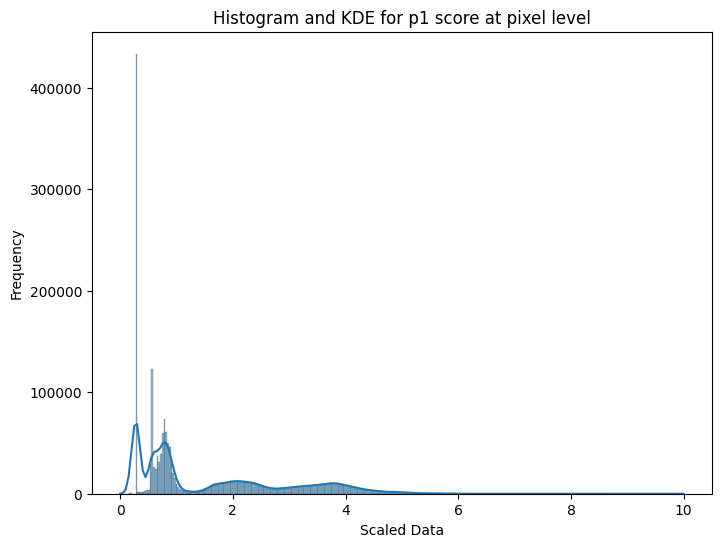

In [68]:
# Check normality using D'Agostino-Pearson test
current_skew = skew(indicator_normalized)
current_kurtosis = kurtosis(indicator_normalized)
print(f"p1 score at pixel level skew={current_skew:.3f}, kurtosis={current_kurtosis:.3f}")

# Plot histogram and normality check
plt.figure(figsize=(8, 6))
sns.histplot(indicator_normalized, kde=True)
plt.title(f"Histogram and KDE for p1 score at pixel level")
plt.xlabel("Scaled Data")
plt.ylabel("Frequency")
plt.show()

In [69]:

# Export the geometric average as a GeoTIFF
output_folder = "/content/drive/MyDrive/CCRI_results_misc"
output_path = os.path.join(output_folder, "p1_avg_pixel.tif")

# Use the profile from an existing image to match metadata
with rasterio.open(os.path.join(image_folder, image_files[0])) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float32, count=1)

indicator_raster = indicator_raster.reshape(profile['height'], profile['width'])

# Write the result to a GeoTIFF
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(indicator_raster, 1)

print(f"Risk Sum image exported to {output_path}")

Risk Sum image exported to /content/drive/MyDrive/CCRI_results_misc/p1_avg_pixel.tif


In [70]:
# Get the PCA loadings (eigenvectors)
loadings = pca.components_

# Create a DataFrame to display the relationship between hazard layers and PCs
hazard_layers = ['_'.join(file.split('/')[-1].split('_')[:2]) for file in image_files]  # Clean names
loadings_df = pd.DataFrame(loadings.T, index=hazard_layers, columns=[f'PC{i+1}' for i in range(loadings.shape[0])])

# Sort and display the most influential layers for each PC
print(loadings_df)

# Plot the heatmap showing the relationship between hazard layers and principal components
plt.figure(figsize=(10, 6))
sns.heatmap(loadings_df, annot=True, cmap="coolwarm", center=0)
plt.title("PCA Loadings (Hazard Layers vs Principal Components)")
plt.xlabel("Principal Components")
plt.ylabel("Hazard Layers")
plt.show()

ValueError: Shape of passed values is (96, 8), indices imply (17, 8)

In [71]:
hazard_layers

['heatwave_severity',
 'coastal_flood',
 'extreme_heat',
 'river_flood',
 'vectorborne_malariapf',
 'landSeaMask.tif',
 'drought_sma',
 'heatwave_frequency',
 'fire_FRP',
 'tropical_storm',
 'heatwave_duration',
 'sand_dust',
 'air_pollution',
 'agricultural_drought',
 'drought_spi',
 'fire_frequency',
 'vectorborne_malariapv']

In [ ]:
layers = land_pixels_scaled.shape[1]
hazard_layers_arr = []  # Use list initialization

for i in range(layers):
    print(i)
    hazard_image = np.full_like(landsea_mask, np.nan, dtype=np.float32)
    hazard_image[land_mask] = land_pixels_scaled[:, i].flatten()
    hazard_layers_arr.append(hazard_image)  # Use append() instead of add()

# Define the folder where you want to save the multi-band image
output_path = "/content/drive/MyDrive/clustering_image/hazard_layers_multiband.tif"

# Stack the hazard layers into a multi-band array (each hazard layer is a band)
hazard_layers_stack = np.stack(hazard_layers_arr, axis=-1)

# Use the profile from an existing image to match metadata
with rasterio.open(os.path.join(image_folder, image_files[0])) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float32, count=hazard_layers_stack.shape[-1])  # Update the band count

# Write the multi-band image to a GeoTIFF
with rasterio.open(output_path, 'w', **profile) as dst:
    for i in range(hazard_layers_stack.shape[-1]):
        dst.write(hazard_layers_stack[:, :, i], i + 1)  # Write each band

print(f"Multi-band hazard layers exported to {output_path}")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
Multi-band hazard layers exported to /content/drive/MyDrive/clustering_image/hazard_layers_multiband.tif


In [ ]:
print(f"Min value of risk_sum: {np.min(risk_sum)}")
print(f"Max value of risk_sum: {np.max(risk_sum)}")

Min value of risk_sum: 0.0
Max value of risk_sum: 5.581412315368652


In [ ]:
print(f"Min value after scaling: {risk_sum_normalized.min()}")
print(f"Max value after scaling: {np.sum(risk_sum_normalized[risk_sum_normalized>=0.7])}")

Min value after scaling: 0.0
Max value after scaling: 2814.47119140625


In [ ]:
import numpy as np

# Assuming risk_sum_normalized is your array
mean_risk_sum = np.mean(risk_sum_normalized)
std_risk_sum = np.std(risk_sum_normalized)

# Calculate mean + 2 standard deviations and mean + 1 standard deviation
mean_plus_2sd = mean_risk_sum + 2 * std_risk_sum
mean_plus_1sd = mean_risk_sum + std_risk_sum

# Calculate specific percentiles
percentile_75 = np.percentile(risk_sum_normalized, 75)
percentile_90 = np.percentile(risk_sum_normalized, 90)
percentile_95 = np.percentile(risk_sum_normalized, 95)
percentile_99 = np.percentile(risk_sum_normalized, 99)

# Print the results
print(f"Mean of risk_sum_normalized: {mean_risk_sum}")
print(f"Mean + 1 Standard Deviation: {mean_plus_1sd}")
print(f"Mean + 2 Standard Deviations: {mean_plus_2sd}")
print(f"75th Percentile: {percentile_75}")
print(f"90th Percentile: {percentile_90}")
print(f"95th Percentile: {percentile_95}")
print(f"99th Percentile: {percentile_99}")


Mean of risk_sum_normalized: 0.32562756538391113
Mean + 1 Standard Deviation: 0.49461814761161804
Mean + 2 Standard Deviations: 0.663608729839325
75th Percentile: 0.4432218670845032
90th Percentile: 0.5403158962726593
95th Percentile: 0.5796858668327332
99th Percentile: 0.6493283420801161


In [ ]:
import numpy as np
import rasterio
from scipy.stats import gmean

# Calculate the geometric average across the bands for each pixel
# The land_pixels_scaled is a 2D array where rows are land pixels, and columns are bands

# Apply geometric mean across the bands (axis=1 represents the band dimension)
geometric_average = gmean(land_pixels_scaled, axis=1)

# Reshape the geometric average back to the original shape of the land-sea mask
geometric_average_image = np.zeros_like(landsea_mask, dtype=np.float32)
geometric_average_image[land_mask] = geometric_average

# Export the geometric average as a GeoTIFF
output_path = "/content/geometric_average.tif"

# Use the profile from an existing image to match metadata
with rasterio.open(os.path.join(image_folder, image_files[0])) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float32, count=1)

# Write the result to a GeoTIFF
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(geometric_average_image, 1)

print(f"Geometric average image exported to {output_path}")


In [ ]:
import pandas as pd

# List of CSV filenames corresponding to the different thresholds
csv_files = [
    "/content/drive/MyDrive/Risk_Exposure_ByAOI_adm0_Mean.csv",
    "/content/drive/MyDrive/Risk_Exposure_ByAOI_adm0_MeanPlus1SD.csv",
    "/content/drive/MyDrive/Risk_Exposure_ByAOI_adm0_MeanPlus2SD.csv",
    "/content/drive/MyDrive/Risk_Exposure_ByAOI_adm0_Percentile75.csv",
    "/content/drive/MyDrive/Risk_Exposure_ByAOI_adm0_Percentile90.csv",
    "/content/drive/MyDrive/Risk_Exposure_ByAOI_adm0_Percentile95.csv",
    "/content/drive/MyDrive/Risk_Exposure_ByAOI_adm0_Percentile99.csv"
]

# Loop through each CSV file and compute the total exposed population
for csv_file in csv_files:
    df_exp = pd.read_csv(csv_file)
    total_exposed = df_exp['child_population_exposed'].sum()

    # Print the total exposed population for each threshold
    print(f"Total exposed population in {csv_file.split('/')[-1]}: {total_exposed}")


Total exposed population in Risk_Exposure_ByAOI_adm0_Mean.csv: 1858104029.139358
Total exposed population in Risk_Exposure_ByAOI_adm0_MeanPlus1SD.csv: 811696463.8367901
Total exposed population in Risk_Exposure_ByAOI_adm0_MeanPlus2SD.csv: 72040429.87219438
Total exposed population in Risk_Exposure_ByAOI_adm0_Percentile75.csv: 1213401250.2680993
Total exposed population in Risk_Exposure_ByAOI_adm0_Percentile90.csv: 522847747.2990949
Total exposed population in Risk_Exposure_ByAOI_adm0_Percentile95.csv: 264639434.26495135
Total exposed population in Risk_Exposure_ByAOI_adm0_Percentile99.csv: 72892719.63412817
